# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, breaks_cusumolsresid
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

from scipy.stats import yeojohnson, yeojohnson_normmax, jarque_bera
from scipy.stats.mstats import winsorize

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings

from pmdarima import auto_arima
from arch import arch_model

# Data Loading & Visualisation

In [2]:
# Load the data
qqq = pd.read_excel('../data/qqq_data.xlsx', 
                    index_col=0, parse_dates=True)
macro = pd.read_excel('../data/macro_data.xlsx', 
                      index_col=0, parse_dates=True)

# Check the data
display(qqq.head())
display(macro.head())

,ETF_Ticker,ETF_Open,ETF_High,ETF_Low,ETF_Close,ETF_Volume,ETF_Return,Benchmark_Return,Benchmark_Volatility,Tracking_Error,...,Dividend_Yield_pct,Beta,Expense_Ratio_pct,Fund_Family,Fund_Category,Inception_Date,Pct_in_Top10_Holdings,Total_Holdings,Optionable,Shortable
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,QQQ,34.320947,34.492167,31.213309,32.018024,2234773200,-0.063126,-0.062605,0.010865,-0.000522,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-02-01,QQQ,32.095091,32.942606,31.418755,31.863935,1765610600,-0.004813,-0.005666,0.010056,0.000853,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-03-01,QQQ,31.992344,32.779963,30.768126,31.307474,2133973700,-0.017464,-0.018855,0.008751,0.001391,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-04-01,QQQ,31.521498,31.735519,29.406934,29.946276,2345433600,-0.043478,-0.041645,0.012613,-0.001833,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-05-01,QQQ,30.049009,32.762837,29.869230,32.600197,1881340000,0.088623,0.085755,0.006330,0.002868,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True


,vix,michigan_consumer_sentiment_index
2005-01-01,12.82,95.5
2005-02-01,12.08,94.1
2005-03-01,14.02,92.6
2005-04-01,15.31,87.7
2005-05-01,13.29,86.9


In [3]:
# Get information about the data
print("QQQ Data Info:")
display(qqq.describe())
print("\nMacro Data Info:")
display(macro.describe())

QQQ Data Info:


,ETF_Open,ETF_High,ETF_Low,ETF_Close,ETF_Volume,ETF_Return,Benchmark_Return,Benchmark_Volatility,Tracking_Error,Absolute_Tracking_Error,Net_Assets_USD,NAV_USD,PE_Ratio,Dividend_Yield_pct,Beta,Expense_Ratio_pct,Inception_Date,Pct_in_Top10_Holdings,Total_Holdings
count,240.000000,240.000000,240.000000,240.000000,2.400000e+02,240.000000,240.000000,240.000000,240.000000,240.000000,2.400000e+02,2.400000e+02,240.00000,240.0,240.00,240.0,240,240.000000,240.0
mean,141.854185,148.410727,135.854721,143.609570,1.380399e+09,0.012765,0.012160,0.012097,0.000605,0.001171,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
min,23.522952,26.702119,21.696006,23.878576,3.074376e+08,-0.155763,-0.162953,0.002915,-0.007349,0.000002,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
25%,41.132771,43.758852,39.327759,41.804646,6.974952e+08,-0.018018,-0.018936,0.007918,-0.000234,0.000434,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
50%,94.027525,97.665560,90.360646,95.052735,1.008536e+09,0.017680,0.017121,0.010193,0.000628,0.000892,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
75%,192.992068,208.999052,183.989309,198.462799,1.776189e+09,0.048497,0.047817,0.014446,0.001344,0.001540,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
max,509.427621,537.480547,507.712944,514.842224,7.240780e+09,0.149738,0.151918,0.057591,0.008237,0.008237,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
std,126.109204,132.364382,120.760418,127.951458,9.793356e+08,0.052866,0.052700,0.006933,0.001482,0.001090,0.000000e+00,1.139244e-13,0.00000,0.0,0.00,0.0,NaN,0.000000,0.0



Macro Data Info:


,vix,michigan_consumer_sentiment_index
count,240.000000,240.000000
mean,19.299542,80.122083
std,8.250237,12.798809
min,9.510000,50.000000
25%,13.535000,70.450000
50%,16.810000,80.200000
75%,22.990000,91.550000
max,59.889999,101.400000


In [4]:
# y=0 dashed line
def add_zero_line(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.axhline(0, linestyle='--', color='gray', linewidth=1)

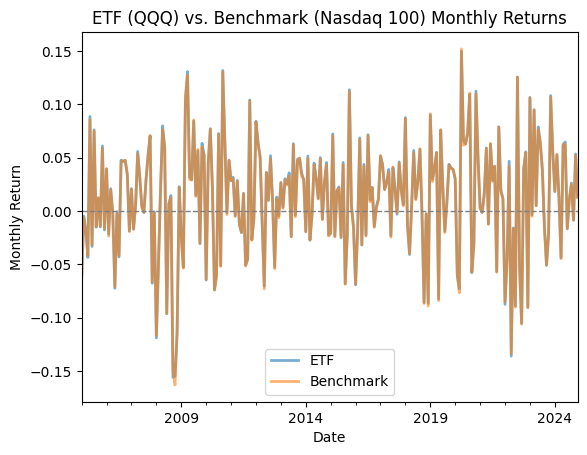

In [5]:
# ETF Returns vs Benchmark Returns
plt.figure()
ax = qqq['ETF_Return'].plot(alpha=0.6, linewidth=2, label='ETF')
qqq['Benchmark_Return'].plot(alpha=0.6, linewidth=2, label='Benchmark', ax=ax)
add_zero_line(ax)
plt.title('ETF (QQQ) vs. Benchmark (Nasdaq 100) Monthly Returns')
plt.xlabel('Date'); plt.ylabel('Monthly Return')
plt.legend()
plt.show()

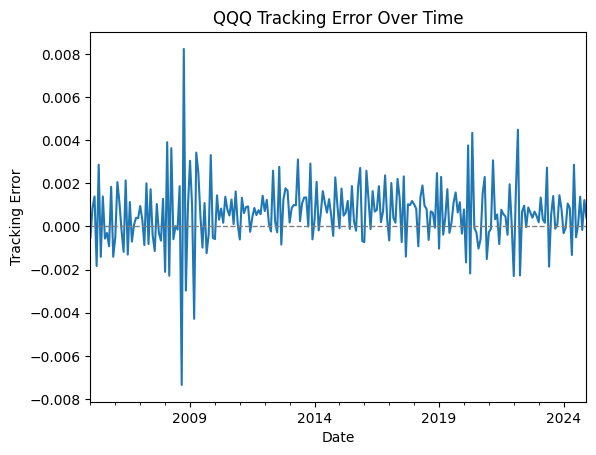

In [6]:
# Tracking Error Plot
plt.figure()
ax = qqq['Tracking_Error'].plot()
add_zero_line(ax)
plt.title('QQQ Tracking Error Over Time')
plt.xlabel('Date'); plt.ylabel('Tracking Error')
plt.show()

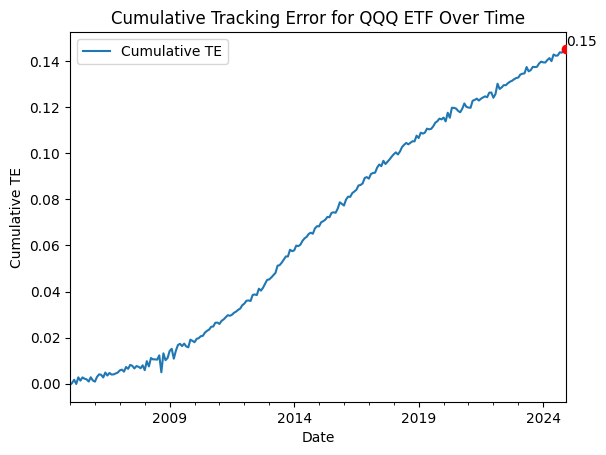

In [7]:
# Cumulative Tracking Error with final‐value marker
cum_te = qqq['Tracking_Error'].cumsum()
plt.figure()
ax = cum_te.plot(label='Cumulative TE')
# Mark & annotate final point
last_date = cum_te.index[-1]
last_val  = cum_te.iloc[-1]
ax.scatter([last_date], [last_val], color='red', zorder=5)
ax.text(last_date, last_val,
        f"{last_val:.2f}",
        va='bottom', ha='left')

plt.title('Cumulative Tracking Error for QQQ ETF Over Time')
plt.xlabel('Date'); plt.ylabel('Cumulative TE')
plt.legend()
plt.show()

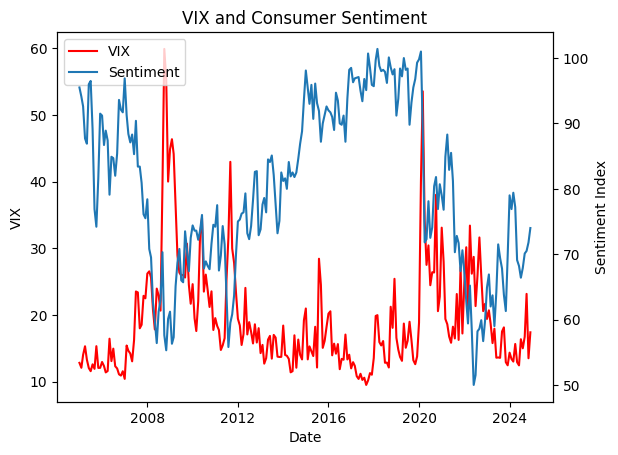

In [8]:
# VIX & Sentiment plots
fig, ax1 = plt.subplots()
ax1.plot(macro['vix'], label='VIX', color='r')
ax1.set_xlabel('Date'); ax1.set_ylabel('VIX')

ax2 = ax1.twinx()
ax2.plot(macro['michigan_consumer_sentiment_index'], label='Sentiment')
ax2.set_ylabel('Sentiment Index')

# combine legends
lines1, labs1 = ax1.get_legend_handles_labels()
lines2, labs2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labs1+labs2, loc='upper left')
plt.title('VIX and Consumer Sentiment')
plt.show()

# ARIMA Model Fitting

In [19]:
warnings.filterwarnings('ignore')

def inv_yeojohnson(x, lmbda):
    x = np.array(x, dtype=float)
    y = np.zeros_like(x)
    pos, neg = x >= 0, x < 0
    if lmbda != 0:
        y[pos] = np.power(x[pos]*lmbda + 1, 1/lmbda) - 1
    else:
        y[pos] = np.exp(x[pos]) - 1
    if lmbda != 2:
        y[neg] = 1 - np.power((-x[neg]*(2-lmbda) + 1), 1/(2-lmbda))
    else:
        y[neg] = 1 - np.exp(-x[neg])
    return y

def fit_seasonal_winsor_arima_garch(
    series: pd.Series,
    n: int = 3,
    winsor_limits: tuple = (0.01, 0.01),
    seasonal_period: int = 12,
    ljungbox_lags: int = 10,
    alpha: float = 0.05,
    plot: bool = False,
    forecast_plot: bool = False
) -> dict:
    """
    series          : monthly pd.Series of TE
    n               : forecast horizon
    winsor_limits   : top/bottom fraction to clamp (e.g. (0.01,0.01))
    seasonal_period : period for SARIMA
    plot            : show ACF/PACF & QQ plots if True
    forecast_plot   : show last 10 obs + forecast if True
    """
    y = series.dropna()
    if len(y) <= n + 10:
        raise ValueError(f"Need at least n+10 observations; got {len(y)}.")
    
    # 1) split & winsorize
    train_raw, test_raw = y.iloc[:-n], y.iloc[-n:]
    w = winsorize(train_raw.values, limits=winsor_limits)
    train_w = pd.Series(w, index=train_raw.index)

    # 2) Yeo–Johnson
    shift   = -train_w.min() + 1e-6
    shifted = train_w + shift
    lam     = yeojohnson_normmax(shifted)
    train_t = yeojohnson(shifted, lmbda=lam)

    # 3) Seasonal ARIMA via BIC
    am = auto_arima(
        train_t,
        seasonal=True, m=seasonal_period,
        information_criterion='bic',
        max_p=5, max_q=5, max_d=2,
        max_P=2, max_Q=2, max_D=1,
        maxiter=20,
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore'
    )
    p,d,q    = am.order
    P,D,Q,m  = am.seasonal_order
    res      = am.arima_res_
    resid    = pd.Series(res.resid).dropna()
    aic, bic = float(res.aic), float(res.bic)

    # 4) invert fits & forecasts
    fit_t  = am.predict_in_sample()
    fc_t   = am.predict(n_periods=n)
    fitted = inv_yeojohnson(fit_t, lam) - shift
    fcst   = inv_yeojohnson(fc_t,  lam) - shift

    # 5) diagnostic tests
    def run_diag(r):
        out = {}
        lb = acorr_ljungbox(r, lags=[ljungbox_lags], return_df=True).iloc[0]
        out['Ljung-Box']   = (lb['lb_stat'], lb['lb_pvalue'])
        jb_s,jb_p          = jarque_bera(r)[:2]
        out['Jarque-Bera'] = (jb_s, jb_p)
        arch_s,arch_p,_,_  = het_arch(r, nlags=ljungbox_lags)
        out['ARCH LM']     = (arch_s, arch_p)
        cb = breaks_cusumolsresid(r, ddof=0)
        out['CUSUM']       = (cb[0], np.min(np.atleast_1d(cb[-1])))
        return out

    diag_arima  = run_diag(resid)
    gmod        = arch_model(resid, vol='Garch', p=1, q=1,
                             dist='t', rescale=False)
    gres        = gmod.fit(disp='off')
    std_resid   = pd.Series(gres.std_resid).dropna()
    diag_garch  = run_diag(std_resid)

    # 6) metrics
    metrics = {
        'in_sample': {
            'R²':  r2_score(train_raw,   fitted),
            'MAE': mean_absolute_error(train_raw, fitted),
            'MSE': mean_squared_error(train_raw, fitted)
        },
        'out_sample': {
            'R²':  r2_score(test_raw,    fcst),
            'MAE': mean_absolute_error(test_raw,    fcst),
            'MSE': mean_squared_error(test_raw,    fcst)
        }
    }

    # 7) pretty-print
    print("\n" + "="*60)
    print(f" Seasonal ARIMA: ({p},{d},{q})×({P},{D},{Q})[{m}]   AIC={aic:.2f}   BIC={bic:.2f}")
    print("="*60 + "\n")
    def fmt(di):
        df = pd.DataFrame(di, index=['stat','pvalue']).T
        df['Result'] = np.where(df['pvalue']>alpha, 'Pass','Fail')
        return df[['stat','pvalue','Result']]
    print(" ARIMA residual diagnostics:")
    print(fmt(diag_arima).to_string(float_format='%.4f'))
    print("\n GARCH std-residual diagnostics:")
    print(fmt(diag_garch).to_string(float_format='%.4f'))
    dfm = pd.DataFrame(metrics).T.rename_axis('sample')
    print("\n Forecast metrics:")
    print(dfm.to_string(float_format='%.6f'))
    print("="*60 + "\n")

    # 8) optional diagnostic plots
    if plot:
        def plot_resid(r, title):
            fig, ax = plt.subplots(2,2,figsize=(10,6))
            plot_acf(r, lags=40, ax=ax[0,0]); ax[0,0].set_title(f'ACF {title}')
            plot_pacf(r, lags=40, ax=ax[0,1]); ax[0,1].set_title(f'PACF {title}')
            ax[1,0].hist(r, bins=30, edgecolor='k'); ax[1,0].set_title(f'Hist {title}')
            qqplot(r, line='s', ax=ax[1,1]); ax[1,1].set_title(f'QQ {title}')
            plt.tight_layout(); plt.show()

        fig, ax = plt.subplots(1,2,figsize=(12,3))
        series.plot(ax=ax[0], title='Original Series')
        ax[1].plot(resid, color='tab:orange'); ax[1].set_title('ARIMA Residuals')
        plt.show()
        plot_resid(resid,     'ARIMA Residuals')
        plot_resid(std_resid, 'GARCH Std Residuals')
        rv = resid.rolling(window=seasonal_period).var()
        plt.figure(figsize=(8,3))
        plt.plot(rv); plt.title(f'{seasonal_period}-period Rolling Var'); plt.show()

    # 9) optional forecast vs actual plot
    if forecast_plot:
        preview_n = 10
        y_full    = y  # your full pd.Series of actual TE
        
        # index where forecasts start
        split = len(y_full) - n
        
        # preview window (10 points immediately before forecast)
        start = max(0, split - preview_n)
        idx_preview = y_full.index[start:split]
        vals_preview = y_full.iloc[start:split].values
        
        # 1) forecast series = preview_vals + forecast_vals
        fc_idx   = list(idx_preview) + list(test_raw.index)
        fc_vals  = np.concatenate([vals_preview, fcst])
        fc_series = pd.Series(fc_vals, index=fc_idx)
        
        # 2) actual series = preview_vals + actual_vals for test months
        actual_idx  = list(idx_preview) + list(test_raw.index)
        actual_vals = np.concatenate([vals_preview, test_raw.values])
        actual_series = pd.Series(actual_vals, index=actual_idx)
        
        # 3) plot forecast behind
        fig, ax = plt.subplots(figsize=(10,5))
        fc_series.plot(
            ax=ax,
            style='--o',
            color='C1',
            label='Forecast',
            zorder=1
        )
        # 4) plot actual on top (hides preview dashed)
        actual_series.plot(
            ax=ax,
            style='-o',
            color='C0',
            label='Actual',
            zorder=2
        )
        
        ax.set_title(f'Last {preview_n} Actuals + {n}-step Forecast')
        ax.set_xlabel('Date')
        ax.set_ylabel(series.name or 'Value')
        ax.legend()
        plt.show()

    return {
        'order':       (p,d,q,P,D,Q,m),
        'aic':         aic,
        'bic':         bic,
        'diagnostics': {'arima': diag_arima, 'garch': diag_garch},
        'metrics':     metrics
    }


 Seasonal ARIMA: (2,1,1)×(1,0,1)[12]   AIC=-2569.43   BIC=-2545.18

 ARIMA residual diagnostics:
               stat  pvalue Result
Ljung-Box   31.3310  0.0005   Fail
Jarque-Bera  3.2059  0.2013   Pass
ARCH LM     29.1831  0.0012   Fail
CUSUM        1.0261  1.0000   Pass

 GARCH std-residual diagnostics:
                   stat  pvalue Result
Ljung-Box        0.0000  1.0000   Pass
Jarque-Bera 540774.5560  0.0000   Fail
ARCH LM        213.9136  0.0000   Fail
CUSUM            1.1402  1.0000   Pass

 Forecast metrics:
                 R²      MAE      MSE
sample                               
in_sample  0.264955 0.000900 0.000002
out_sample 0.459988 0.000352 0.000000



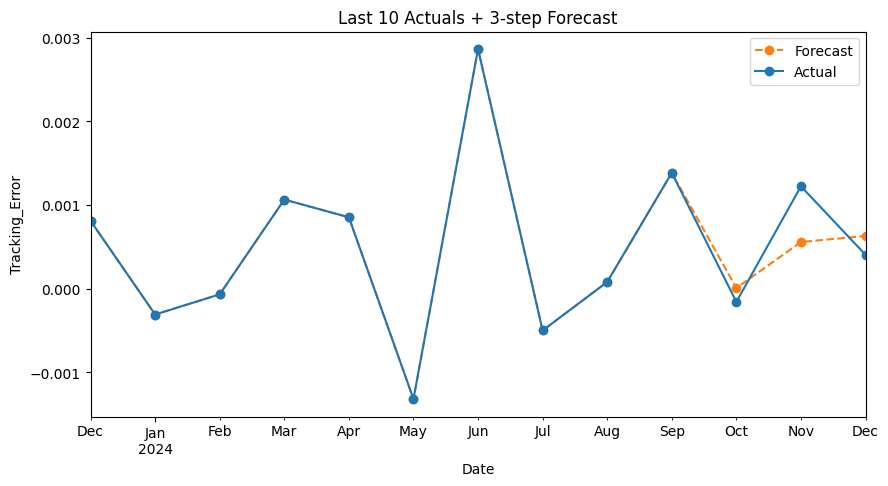

In [20]:
results = fit_seasonal_winsor_arima_garch(
    qqq['Tracking_Error'],
    n=3,
    winsor_limits=(0.01,0.01),
    seasonal_period=12,
    plot=False,
    forecast_plot=True
)
